In [17]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
from torch import nn
import argparse
import glob
from tensorboardX import SummaryWriter
import pandas as pd

import pathlib
import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm



In [18]:
def parse_command_line():
    parser = argparse.ArgumentParser()
    parser.add_argument('-n', '--net', type=str, default='simpleLSTM', help='task to be trained')
    parser.add_argument('-f', '--file', type=str, default='simpleLSTM', help='tensorboard location')
    parser.add_argument('-r', '--runs', type=str, default='test/simpleLSTM', help='tensorboard location')
    parser.add_argument('-b', '--batchsize', type=int, default=64, help='batchsize')
    parser.add_argument('-m', '--max', type=int, default=20, help='batchsize')
    parser.add_argument('-l', '--force_learning_rate', type=float, default=0.00001, help='setting learning rate')
    args = parser.parse_args()
    return args

In [19]:
opt = parse_command_line()
writer = SummaryWriter(opt.runs)
params = { 'batch_size': opt.batchsize, 'shuffle': True, 'num_workers': 10, 'drop_last': True}
learning_rate = opt.force_learning_rate

data = {'Data_hz': 2, 'Frame_len': 25}


In [20]:
def get_filename_type(file):
    filename = file.split("/")[-1].split('.')[:-1]
    file_type = file.split("/")[-1].split('.')[-1]
    return filename, file_type



In [21]:
class my_dataset(Dataset):
    def __init__(self, csv_path_folder, npy_path_folder, data_hz, frame_len):
        
        self.data_hz = data_hz
        self.frame_len = frame_len

        # txt
        self.csv_filenames = sorted(glob.glob(csv_path_folder))
        self.csv_list_of_dfs = [np.loadtxt(filename, dtype=np.long) for filename in self.csv_filenames]
        self.csv_dataframes = {}
        self.csv_filename = []
        self.csv_result = []
        for csv_dataframe, csv_filename in zip(self.csv_list_of_dfs, self.csv_filenames):
            tmp_name,_= get_filename_type(csv_filename)
            self.csv_filename.append(tmp_name)
            self.csv_dataframes[csv_filename] = csv_dataframe
        for i in self.csv_list_of_dfs:
            for j in range(len(i)-(self.frame_len-1)*self.data_hz):
                tmp_list=[]
                for k in range(self.frame_len):
                    tmp_list.append(i[j+k*self.data_hz].argmax(axis=0))
                    #tmp_list.append(i[j+k*self.data_hz])
                self.csv_result.append(tmp_list[-1])
        self.csv_conbined_df = np.concatenate(self.csv_list_of_dfs)
        self.csv_torch_tensor = torch.tensor(self.csv_conbined_df)
        print(self.csv_result[0])
        # npy
        self.npy_filenames = sorted(glob.glob(npy_path_folder))
        self.npy_list_of_frames = [np.load(filename) for filename in self.npy_filenames]
        self.npy_inputs = {}
        self.npy_filename = []
        self.npy_result = []

        for i in self.npy_list_of_frames:
            for j in range(len(i)-(self.frame_len-1)*self.data_hz):
                tmp_list=[]
                for k in range(self.frame_len):
                    tmp_list.append(np.concatenate(i[j+k*self.data_hz]))
                self.npy_result.append(tmp_list)

        for npy_input, npy_filename in zip(self.npy_list_of_frames, self.npy_filenames):
            tmp_name,_= get_filename_type(npy_filename)
            if tmp_name not in self.csv_filename:
                self.npy_inputs[npy_filename] = npy_input
        self.npy_conbined_inputs = np.concatenate(self.npy_list_of_frames, axis=0, out=None)
        self.npy_torch_tensor = torch.tensor(self.npy_conbined_inputs)
        
        print("length of input skeleton is:"+str(len(self.npy_conbined_inputs))+" mod of batch size is:"+str(len(self.npy_conbined_inputs)%params['batch_size']))
        print("length of input label is:"+str(len(self.csv_conbined_df))+" mod of batch size is:"+str(len(self.csv_conbined_df)%params['batch_size']))

    def __len__(self):
        return len(self.csv_result)

    def __getitem__(self, index):
        return np.asarray(self.npy_result[index]),np.asarray(self.csv_result[index])


In [22]:
class BlockLSTM(nn.Module):
    def __init__(self, time_steps, num_variables, num_classes, lstm_hs=64, dropout=0.8, attention=False):
        super().__init__()
        #self.lstm = nn.LSTM(input_size=num_variables, hidden_size=lstm_hs, num_layers=time_steps)
        
        self.lstm = nn.LSTM(input_size=time_steps, hidden_size=lstm_hs, num_layers=num_variables)
        #self.dropout = nn.Dropout(p=dropout)
        #self.fc = nn.Linear(lstm_hs, num_classes)
        self.dense = nn.Linear(lstm_hs, num_classes)
        self.softmax = nn.LogSoftmax(dim=1) #nn.Softmax(dim=1)
    def forward(self, x):
        # (batch_size, num_variables, time_steps), e.g. (128, 1, 512)
        # x = torch.transpose(x, 0, 1)
        # (num_variables, batch_size, time_steps)
        x,_ = self.lstm(x)
        # dropout layer input shape:
        # y = self.dropout(x)
        # output shape is of the form ()
        #y = self.fc(x)
        print(x[:, -1, :].size())
        x = self.dense(x[:, -1, :])
        #x = torch.squeeze(x)
        # pass through Softmax activation
        y = self.softmax(x)
        return y

In [23]:
class simpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(simpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()

        out, (h_n, h_c) = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        #return out
        return F.log_softmax(x,dim=1)

In [24]:
class SimpleLearner():
    def __init__(self, data, model, loss_func, wd = 1e-5):
        self.data, self.model, self.loss_func = data , model , loss_func 
        self.wd = wd
    
    def update_manualgrad(self, x,y,lr):
        y_hat = self.model(x)
        # weight decay
        w2 = 0.
        for p in model.parameters(): w2 += (p**2).sum()
        # add to regular loss
        loss = self.loss_func(y_hat, y) + w2 * self.wd
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p.sub_(lr * p.grad)
                p.grad.zero_()
        return loss.item()

    def update(self, x,y,lr):
        x = x.view(-1, 1, 2400).cuda()
        y = y.cuda()
        opt = optim.Adam(self.model.parameters(), lr)
        y_hat = self.model(x)
        loss = self.loss_func(y_hat, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        return loss.item()

    def fit(self, epochs=1, lr=1e-3):
        """Train the model"""
        losses = []
        for i in range(epochs):
            for x,y in self.data[0]:
                current_loss = self.update(x, y , lr)
                losses.append(current_loss)
        return losses
    
    def evaluate(self, X):
        """Evaluate the given data loader on the model and return predictions"""
        result = None
        gt = None
        for x, y in X:
            x = x.view(-1, 1, 2400).cuda()
            #y = y.cuda()
            y_hat = self.model(x).cpu().detach().numpy()
            result = y_hat if result is None else np.concatenate((result, y_hat), axis=0)
            gt = y if gt is None else np.concatenate((gt, y), axis=0)
        return result, gt

In [25]:
def real_evaluation(validation_generator):
    y_pred, gt = learner.evaluate(validation_generator)
    result = []
    exp = np.exp(y_pred)
    for i in exp[:,-1]:
        result.append(i.argmax(axis=0))
    return result, gt

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np
def get_mpca(pred, gt): 
    cm = confusion_matrix(gt, pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    result = cm.diagonal()
    return(np.mean(result))


In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np
def get_pca(pred, gt): 
    cm = confusion_matrix(gt, pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    result = cm.diagonal()
    return(result)


In [28]:
from sklearn.metrics import f1_score
def get_f1(pred, gt): 
    f1 = f1_score(gt, pred, average='weighted')
    return(f1)

In [29]:
from sklearn.metrics import accuracy_score
def get_acc(pred, gt):
    acc = accuracy_score(gt, pred)
    return(acc) 

In [30]:
max_epochs = opt.max
max_epochs

20

In [31]:
csv_path = {'train':"/media/data/weiling/Action_Category_CVG/00_datasets/Weiling_data/label_not5/S*.csv", 'val':"/media/data/weiling/Action_Category_CVG/00_datasets/Weiling_data/label_5/S*.csv"}
npy_path = {'train':"/media/data/weiling/Action_Category_CVG/00_datasets/Weiling_data/pose_not5/S*.npy",'val':"/media/data/weiling/Action_Category_CVG/00_datasets/Weiling_data/pose_5/S*.npy"}
csv_path = {'train':"/media/data/weiling/Action_Category_CVG/00_datasets/Weiling_data/fake_label_5/S*.csv", 'val':"/media/data/weiling/Action_Category_CVG/00_datasets/Weiling_data/fake_label_5/S*.csv"}
npy_path = {'train':"/media/data/weiling/Action_Category_CVG/00_datasets/Weiling_data/fake_3d_5/S*.npy",'val':"/media/data/weiling/Action_Category_CVG/00_datasets/Weiling_data/fake_3d_5/S*.npy"}


In [32]:
model = BlockLSTM(time_steps=2400, num_variables=1, num_classes=10 ).cuda()
#model = simpleLSTM(input_size=96, hidden_size=64, num_layers=25, num_classes=10).cuda() 

In [33]:
training_set = my_dataset(csv_path['train'], npy_path['train'], data['Data_hz'],data['Frame_len'])
training_generator = DataLoader(training_set, **params)
validation_set = my_dataset(csv_path['val'], npy_path['val'],data['Data_hz'],data['Frame_len'])
validation_generator = DataLoader(validation_set, **params)

8
length of input skeleton is:4973 mod of batch size is:45
length of input label is:4973 mod of batch size is:45
8
length of input skeleton is:4973 mod of batch size is:45
length of input label is:4973 mod of batch size is:45


In [34]:
# model summary
for m in model.children():
    print(m.training)#, m)
    for j in m.children():
        print(j.training, j)

True
True
True


In [35]:
#class_weight=torch.tensor([51.55064457,9.27501657,5.34769983,3.95367232,61.71075838,0.59068311,2.56887469,0.34336996,0.29221708])
class_weight=torch.tensor([4.63958011e+01,8.34755467e+00,2.09941000e+04,4.81295277e+00,3.55832203e+00,5.55399471e+01,5.31617331e-01,2.31199824e+00,3.09034438e-01,2.62996624e-01])

loss_func = nn.NLLLoss(weight=class_weight).cuda()
#loss_func = nn.CrossEntropyLoss().cuda()

In [36]:
[p.shape for p in model.parameters()]
print(sum(p.numel() for p in model.parameters()))

631946


In [37]:

from torch import optim
lr = 2e-2
learner = SimpleLearner([training_generator, validation_generator], model, loss_func)


In [38]:
losses = learner.fit(4)

torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([6

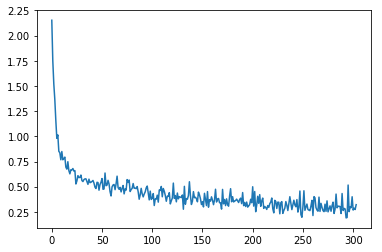

In [39]:
plt.plot(losses)


In [40]:
pred,gt = real_evaluation(validation_generator)
print(get_mpca(pred, gt))
print(get_f1(pred, gt))
print(get_acc(pred,gt))

torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([6

/media/remote_home/weiling/my_envi/pytorch_py3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
